# 2장. Road Following + Working Area Recognition

이번 챕터에서는 Road Following 기능과 Working Area Recognition 기능을 동시에 사용해봅니다.
버튼을 눌러서 Road Following과 Working Area Recognition 을 수행합니다.

인공지능 무인운반로봇(AGV)은 2개 Core로 이루어져 있어서, 2개의 Thread를 돌리는 데 지장이 없습니다.  
Road Following 용 Thread 1개, Working Area Recognition 용 Thread 1개를 동시에 운영하여 버벅임 없이 동작하도록 합니다.

동작 방식
 1. 어떤 Working Area를 이동하면서 물류를 운반할 지 미리 변수 areaA, areaB에 지정합니다.
 > 인공지능 무인운반로봇(AGV)은 areaA -> areaB 순으로 map을 탐색해서 이동합니다.
 2. Start 버튼을 클릭해서 Road Following 을 진행합니다.
 > Start 버튼은 Stop 으로 변경되고, Stop 버튼을 누르면 프로젝트를 종료합니다.
 3. 지정된 Working Area 를 도착했을 때, 정확히 인식하는 지 확인합니다.
 > 인공지능 무인운반로봇(AGV)의 속도, Road Following 의 정확도, 길에서 얼마나 벗어나는 지에 따라 결과가 달라질 수 있습니다.
 4. areaA를 찾는 동안, areaB에 먼저 도착하더라도 무시하고 진행됩니다.

## 라이브러리 가져오기

In [5]:
import torchvision
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F

from IPython.display import display
import ipywidgets
import ipywidgets.widgets as widgets
import traitlets
from robotpal import Robot, Camera, bgr8_to_jpeg
from robotpal.SCSCtrl import TTLServo

import threading
import time
import cv2
import PIL.Image
import numpy as np

## Widget 생성하기

In [6]:
robot = Robot()
camera = Camera()
TTLServo.servoAngleCtrl(5, 45, 1, 100)

model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(512, 2)

# .pth 파일의 경로를 확인
model.load_state_dict(torch.load('best_steering_model_xy_test_12_17.pth'))

device = torch.device('cuda')
model = model.to(device)
model = model.eval().half()

mean = torch.Tensor([0.485, 0.456, 0.406]).cuda().half()
std = torch.Tensor([0.229, 0.224, 0.225]).cuda().half()
print('model load success')


# 최대, 최소 HSV 값 표시하는 레이블 생성
lbl1 = ipywidgets.Label(value="Max :")
colorlblMax = ipywidgets.Label(value="0")
hbox1 = widgets.HBox([lbl1, colorlblMax] )

lbl2 = ipywidgets.Label(value="Min :")
colorlblMin = ipywidgets.Label(value="0")
hbox2 = widgets.HBox([lbl2, colorlblMin])

lbl3 = ipywidgets.Label(value="self.flag :")
flaglbl = ipywidgets.Label(value="None")
hbox3 = widgets.HBox([lbl3, flaglbl])
vbox1 = widgets.VBox([hbox1, hbox2, hbox3])

image_widget = ipywidgets.Image(format='jpeg', width=224, height=224)
x_slider = ipywidgets.FloatSlider(min=-1.0, max=1.0, description='x')
y_slider = ipywidgets.FloatSlider(min=0, max=1.0, orientation='vertical', description='y')
steering_slider = ipywidgets.FloatSlider(min=-1.0, max=1.0, description='steering')
speed_slider = ipywidgets.FloatSlider(min=0, max=1.0, orientation='vertical', description='speed')
vbox2 = widgets.VBox([image_widget, x_slider, steering_slider], layout=widgets.Layout(align_self='center'))
hbox4 = widgets.HBox([vbox2, y_slider, speed_slider], layout=widgets.Layout(align_self='center'))

startBtn = widgets.Button(description="Start", button_style='info')
lbl41 = ipywidgets.Label(value="Find Area : ")
goallbl = ipywidgets.Label(value="None")
hbox5 = widgets.HBox([startBtn,lbl41, goallbl])


#수동 조작용 contorller widget 생성
lbl50 = ipywidgets.Label(value="Manual Controller")

button_layout = widgets.Layout(width='100px', height='80px', align_self='center')
stop_button = widgets.Button(description='stop', button_style='danger', layout=button_layout)
forward_button = widgets.Button(description='forward', layout=button_layout)
backward_button = widgets.Button(description='backward', layout=button_layout)
left_button = widgets.Button(description='left', layout=button_layout)
right_button = widgets.Button(description='right', layout=button_layout)
middle_box = widgets.HBox([left_button, stop_button, right_button], layout=widgets.Layout(align_self='center'))
controls_box = widgets.VBox([lbl50, forward_button, middle_box, backward_button])

#자동 조작용 contorller widget 생성
lbl51 = ipywidgets.Label(value="Auto Controller")
speed_gain_slider = ipywidgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.25, description='speed gain',disabled = False)
steering_gain_slider = ipywidgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.2, description='steering gain',disabled = False)
steering_dgain_slider = ipywidgets.FloatSlider(min=0.0, max=0.5, step=0.001, value=0.5, description='steering kd',disabled = False)
steering_bias_slider = ipywidgets.FloatSlider(min=-0.3, max=0.3, step=0.01, value=0.0, description='steering bias',disabled = False)
vbox3 = widgets.VBox([lbl51,speed_gain_slider, steering_gain_slider, steering_dgain_slider, steering_bias_slider])
hbox6 = widgets.HBox([controls_box, vbox3], layout=widgets.Layout(align_self='center'))

display(vbox1, hbox4,hbox5,hbox6)

manual_btnlst = [stop_button, forward_button, backward_button, left_button, right_button]
camera_link = traitlets.dlink((camera, 'value'), (image_widget, 'value'), transform=bgr8_to_jpeg)

model load success


## 버튼과 함수 바인딩하기

In [7]:
def stop(change):
    robot.stop()
    
def step_forward(change):
    robot.forward(0.4)

def step_backward(change):
    robot.backward(0.4)

def step_left(change):
    robot.left(0.3)
    time.sleep(0.5)
    robot.stop()

def step_right(change):
    robot.right(0.3)
    time.sleep(0.5)
    robot.stop()

stop_button.on_click(stop)
forward_button.on_click(step_forward)
backward_button.on_click(step_backward)
left_button.on_click(step_left)
right_button.on_click(step_right)

# areaA 와 areaB 를 선정
areaA = 'darkblue'
areaB = 'blue'
# 조사한 색상의 이름과 min, max HSV 값을 담은 리스트
colors = [
    {'name': 'red',    'lower': np.array([4,10,201]),   'upper': np.array([34,198,218]) },
    {'name': 'blue',   'lower': np.array([35,8,160]),  'upper': np.array([113,205,221]) },
    {'name': 'darkblue', 'lower': np.array([37,31,43]),  'upper': np.array([119,199,187]) },
    {'name': 'yellow', 'lower': np.array([28, 15, 215]), 'upper': np.array([34,81,219]) },
    {'name': 'orange', 'lower': np.array([20,27,109]), 'upper': np.array([34,144,227]) },
    {'name': 'mint',   'lower': np.array([35,10,212]),  'upper': np.array([71,27,223]) }
]

areaA_color = next((color for color in colors if color['name'] == areaA), None)
areaB_color = next((color for color in colors if color['name'] == areaB), None)


findArea = areaA
goallbl.value = findArea

#frame 크기와 카메라 중심점 좌표 설정
frame_width = 224
frame_height = 224
camera_center_X = int(frame_width/2)
camera_center_Y = int(frame_height/2)

#WorkingAreaFind() 용 리스트와 변수
colorHSVvalueList = []
max_len = 20

#2개 thread 용 객체 변수 생성
roadFinding = None
goalFinding = None

## RobotMoving() 클래스 생성하기

In [8]:
class WorkingAreaFind(threading.Thread):
    def __init__(self):
        super().__init__()
        self.th_flag=True
        self.imageInput = 0
        
        #area 찾는 순서 변수
        self.flag = 1
        flaglbl.value = str(self.flag)
        
    def run(self):
        # while self.th_flag:
        #     self.imageInput = camera.value
        #     #BGR to HSV
        #     hsv = cv2.cvtColor(self.imageInput, cv2.COLOR_BGR2HSV)
        #     #blur
        #     hsv = cv2.blur(hsv, (15, 15))
                        
        #     #areaA, areaB Color searching
        #     areaA_mask = cv2.inRange(hsv, areaA_color['lower'], areaA_color['upper'])
        #     areaA_mask = cv2.erode(areaA_mask, None, iterations=2)
        #     areaA_mask = cv2.dilate(areaA_mask, None, iterations=2)
            
        #     areaB_mask = cv2.inRange(hsv, areaB_color['lower'], areaB_color['upper'])
        #     areaB_mask = cv2.erode(areaB_mask, None, iterations=2)
        #     areaB_mask = cv2.dilate(areaB_mask, None, iterations=2)

        #     # 해당 영역에 대한 윤곽선 따기
        #     AContours, _ = cv2.findContours(areaA_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        #     BContours, _ = cv2.findContours(areaB_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        #     #A영역 or B영역을 찾았다면
        #     if AContours and self.flag == 1:
        #         self.findCenter(areaA, AContours)
            
        #     elif BContours and self.flag == 2:
        #         self.findCenter(areaB, BContours)
            
        #     #두 영역 모두 못찾았다면, 찾아가는 중이다.
        #     else:
        #         cv2.putText(self.imageInput, "Finding...", (0, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,255,255),1,cv2.LINE_AA)
        #         image_widget.value = bgr8_to_jpeg(self.imageInput)
        #     time.sleep(0.1)
        while self.th_flag:
            image = camera.value
            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            hsv = cv2.blur(hsv, (15, 15))
            
            # Center Pixel 의 hsv 값 읽어오기
            hsvValue = hsv[int(frame_height/2), int(frame_width/2)]

            # data 20개 모아서, 최대, 최소 값 구하기
            colorHSVvalueList.append(hsvValue)
            if len(colorHSVvalueList) > max_len:
                del colorHSVvalueList[0]
            max_h,max_s,max_v = np.maximum.reduce(colorHSVvalueList)
            min_h,min_s,min_v = np.minimum.reduce(colorHSVvalueList)

            # Center Pixel 주위에 20x20 크기의 사각형 그리기
            rect_s = 20
            cv2.rectangle(image,
                        (int(frame_width/2)-int(rect_s/2),int(frame_height/2)-int(rect_s/2)),
                        (int(frame_width/2)+int(rect_s/2),int(frame_height/2)+int(rect_s/2)),
                        (255,255,255),1)
            
            # max , min value 표시
            # cv2.putText(image,f'max_HSV:{ max_h,max_s,max_v }',(20,180), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(0,255,255),1,cv2.LINE_AA)
            # cv2.putText(image,f'min_HSV:{ min_h,min_s,min_v }',(20,200), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(255,255,255),1,cv2.LINE_AA)
            colorlblMax.value = str(max_h)+","+ str(max_s)+","+ str(max_v)
            colorlblMin.value = str(min_h)+","+ str(min_s)+","+ str(min_v)
            
            image_widget.value = bgr8_to_jpeg(image)
            time.sleep(0.01)
    
    #name : A, B 구분용도, Contours 각 영역의 윤곽선 값
    def findCenter(self, name, Contours):  
        c = max(Contours, key=cv2.contourArea)
        ((box_x, box_y), radius) = cv2.minEnclosingCircle(c)

        X = int(box_x)
        Y = int(box_y)
        
        error_Y = abs(camera_center_Y - Y)
        error_X = abs(camera_center_X - X)
        
        if error_Y < 15 and error_X < 15:
            #A영역이 가까이 오게됨
            if name == areaA and self.flag == 1:
                self.flag = 2
                findArea = areaB
                goallbl.value = findArea
                
                flaglbl.value = str(self.flag)
                
            #B영역이 가까이 오게됨
            elif name == areaB and self.flag == 2:              
                self.flag = 1       
                findArea = areaB
                goallbl.value = findArea
                
                flaglbl.value = str(self.flag)   
                
        image_widget.value = bgr8_to_jpeg(self.imageInput)
        
    def stop(self):
        self.th_flag = False
        robot.stop()

class RobotMoving(threading.Thread):
    def __init__(self):
        super().__init__()
        self.th_flag = True
    
        self.angle = 0.0
        self.angle_last = 0.0
        
    def run(self):
        while self.th_flag:
            image = camera.value
            xy = model(self.preprocess(image)).detach().float().cpu().numpy().flatten()
            x = xy[0]
            y = (0.5 - xy[1]) / 2.0
            
            x_slider.value = x
            y_slider.value = y
            
            #인공지능 무인운반로봇(AGV)의 속도 표시
            speed_slider.value = 0.23
            
            image_widget.value = bgr8_to_jpeg(image)
            
            #조향값 계산
            self.angle = np.arctan2(x, y)
            
            if not self.th_flag:
                break
            #PID 제어를 이용한 모터 제어
            pid = self.angle * 0.2 + (self.angle - self.angle_last) * 0.5
            self.angle_last = self.angle

            #슬라이더에 표시
            steering_slider.value = pid

            robot.left_motor.value = max(min(speed_slider.value + steering_slider.value, 1.0), -0.9)
            robot.right_motor.value =  max(min(speed_slider.value - steering_slider.value, 1.0), -0.9)
            time.sleep(0.1)
        robot.stop()
    
    def preprocess(self, image):
        image = PIL.Image.fromarray(image)
        image = transforms.functional.to_tensor(image).to(device).half()
        image.sub_(mean[:, None, None]).div_(std[:, None, None])
        return image[None, ...]

    def stop(self):
        self.th_flag = False
        robot.stop()

def start(change):
    global camera_link, goalFinding, roadFinding
    #Manual -> Auto
    if startBtn.description == "Start" :
        camera_link.unlink()
        goalFinding = WorkingAreaFind()
        goalFinding.start()
        roadFinding = RobotMoving()
        roadFinding.start()

        startBtn.button_style = "warning" 
        startBtn.description = "Stop"
    
    #Auto -> Manual
    elif startBtn.description == "Stop":
        roadFinding.stop()
        goalFinding.stop()
        camera_link = traitlets.dlink((camera, 'value'), (image_widget, 'value'), transform=bgr8_to_jpeg)
            
        startBtn.button_style = "info"
        startBtn.description = "Start"

startBtn.on_click(start)

## Start 버튼 함수 바인딩하기

1. Start 버튼을 누르면, Stop 으로 바뀌면서, Road Following 과 Working Area Recognition 기능을 수행합니다.
2. Stop 버튼을 누르면, Road Following 과 Working Area Recognition 을 종료합니다.

실행 결과  
1.	Start 버튼 눌렀을 때, self.flag =1 로, areaA(purple) 찾기 위해 Road Following 수행  
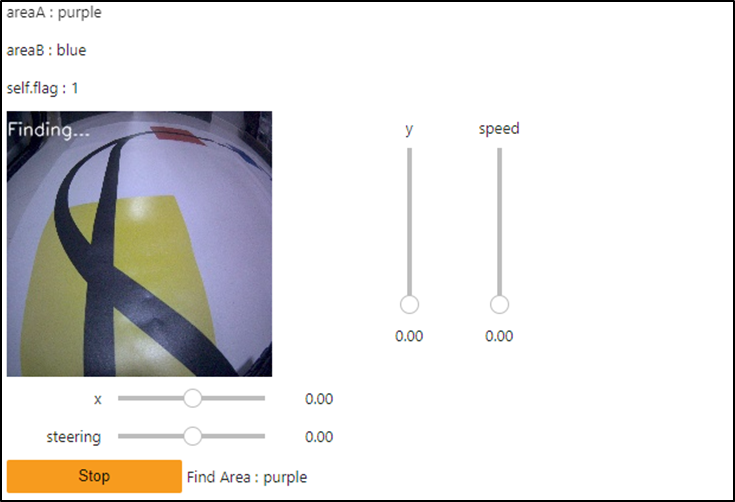

2.	areaA(purple) 를 찾는 도중, areaB(blue) 를 발견해도 무시하고 지나가는 모습  
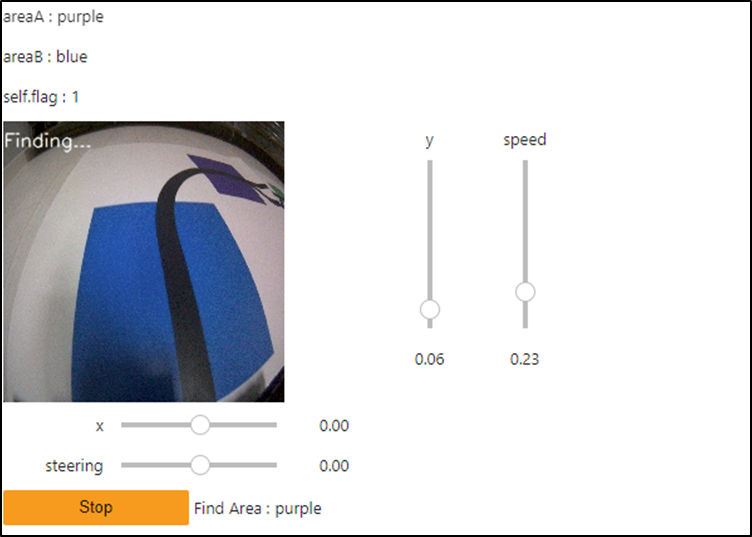

3.	areaA(purple) 에 도착하여 "purple Goal!" 표시, self.flag=2 로 변경, areaB(blue) 를 찾으러 Road Following 수행  
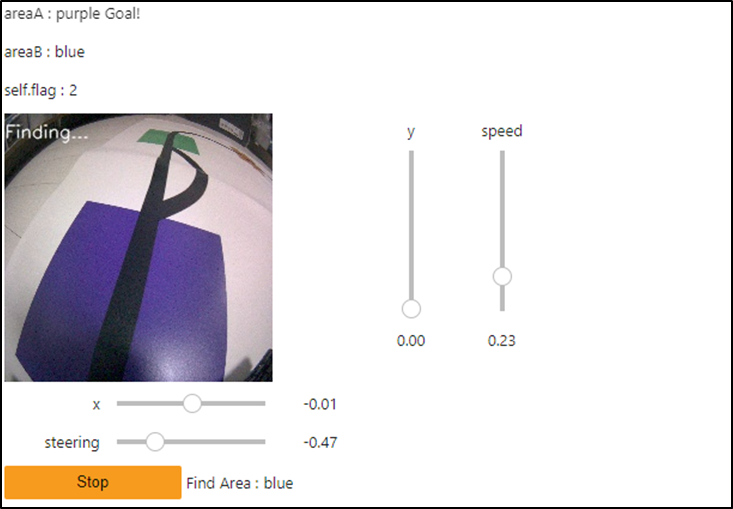

4.	areaB(blue) 에 도착해서 "blue Goal!" 표시, self.flag=1 로 변경, 다시 areaA(purple) 찾으러 Road Following 수행  
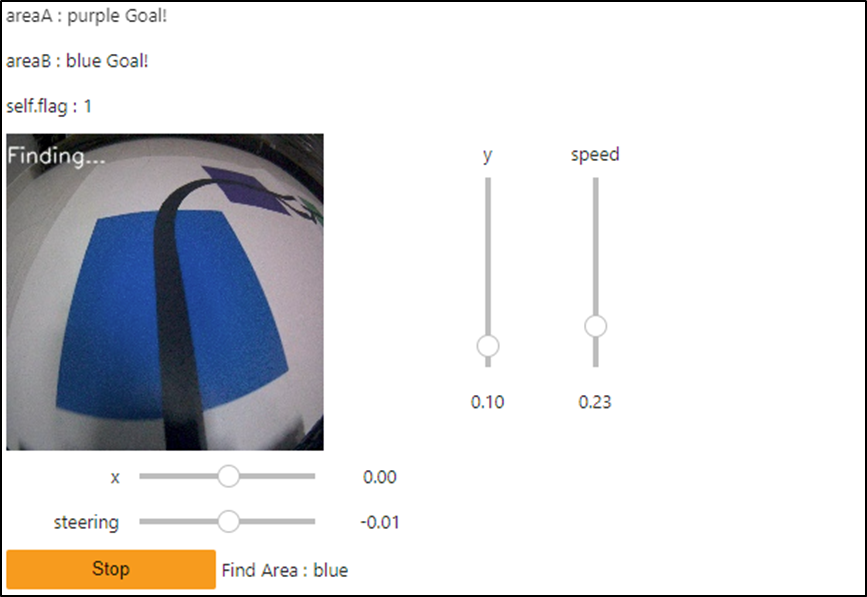

## 프로젝트 종료하기

In [17]:
time.sleep(0.1)
robot.stop()
camera.stop()

print('End')

End
